In [1]:
import pandas as pd 
import numpy as np 

from tools_tolgay import functions_readfiles as readfiles
from tools_tolgay.functions_cloudy import get_fname, read_emissivity_file, read_ovr_file
from tools_tolgay import constants

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 100


from scipy import integrate # flux calculation


In [2]:
# Read all data from Deschenes+2017

base_fdir = "/scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017"
all_data = pd.read_csv(f"{base_fdir}/all_data.txt", sep=',')

condition = all_data['Rgal'] < 10
all_data = all_data[condition]


In [3]:
all_data

,Cloud,Ncomp,Npix,A,l,e_l,b,e_b,theta,WCO,...,Mn,Mf,Lco,hden,isrf,radius,turbulence,12 + log(O/H),metallicity,mass
0,1,6,6,0.093750,-0.560716,0.153933,0.063824,0.125000,28.802170,257.122300,...,3.802615e+05,390888.800,5.231881e+05,106.725555,1.0,26.073500,16.567490,9.173896,3.047165,3.802615e+05
1,2,20,20,0.312500,-0.277576,0.184638,-0.241459,0.138789,10.758150,1115.180000,...,1.660687e+06,1684092.000,7.616266e+06,82.957181,1.0,43.645580,14.316300,9.176952,3.068685,1.660687e+06
2,3,25,25,0.390625,-0.857003,0.194934,-0.259487,0.147484,-17.895130,1439.139000,...,2.093632e+06,2222868.000,1.200230e+07,86.789879,1.0,43.069800,14.635300,9.169207,3.014443,2.093632e+06
3,4,107,87,1.359375,-19.656110,0.321626,-0.096034,0.271538,9.468965,856.856600,...,8.207688e+05,1510622.000,1.637436e+07,9.629998,1.0,66.411290,5.478500,8.993687,2.012271,8.207688e+05
4,5,46,45,0.703125,-0.437401,0.272261,-0.316237,0.202676,9.319308,2062.619000,...,3.029847e+06,3157046.000,3.126493e+07,46.486292,1.0,64.026660,15.174980,9.173469,3.044174,3.029847e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8069,8070,5,5,0.078125,35.000680,0.125000,1.294177,0.125000,-14.977850,3.616060,...,9.518165e+02,8068.112,1.091308e+03,5.151470,1.0,9.116198,2.171081,8.823276,1.359178,9.518165e+02
8095,8096,5,5,0.078125,23.296370,0.125000,-3.612699,0.125000,11.359180,4.438748,...,3.002436e+03,9096.588,3.442453e+03,2.862155,1.0,20.140790,2.348388,8.941870,1.785953,3.002436e+03
8098,8099,5,5,0.078125,16.608000,0.125000,-2.219428,0.125000,-9.426507,6.081343,...,4.768076e+03,13022.110,5.466853e+03,4.159560,1.0,18.987220,2.378863,8.991040,2.000046,4.768076e+03
8102,8103,5,5,0.078125,5.725857,0.125000,-2.165318,0.125000,-25.910900,2.438211,...,2.717708e+03,4663.295,3.115997e+03,1.692112,1.0,18.713350,2.859941,9.095003,2.540988,2.717708e+03


In [4]:
cloud_ids_selected = [36]
mask = all_data['Cloud'].isin(cloud_ids_selected)

single_run = all_data.loc[mask].copy().iloc[0] 

# find centers from the single run 
file_props = {
    'log_hden': np.log10(single_run['hden']),
    'log_metallicity': np.log10(single_run['metallicity']),
    'log_turbulence': np.log10(single_run['turbulence']),
    'log_isrf': np.log10(single_run['isrf']),
    'log_radius': np.log10(single_run['radius']),
}

fname = get_fname(file_props)

# Read the cloudy files 
emissivities = read_emissivity_file(base_dir = base_fdir, file_props = file_props)
abundances = read_ovr_file(base_dir = base_fdir, file_props = file_props)

print(fname)


Reading: /scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643_em.str
Reading: /scratch/dtolgay/cloudy_runs/z_0/miville_deschenes_2017/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643/hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643.ovr
hden1.60345_metallicity0.44367_turbulence0.89142_isrf0.00000_radius1.75643


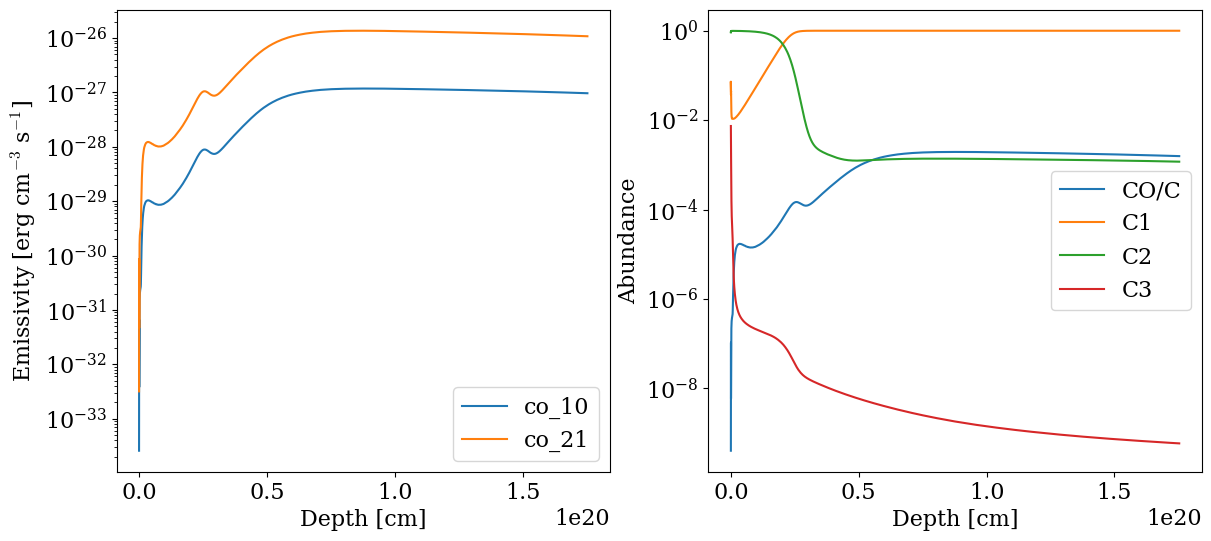

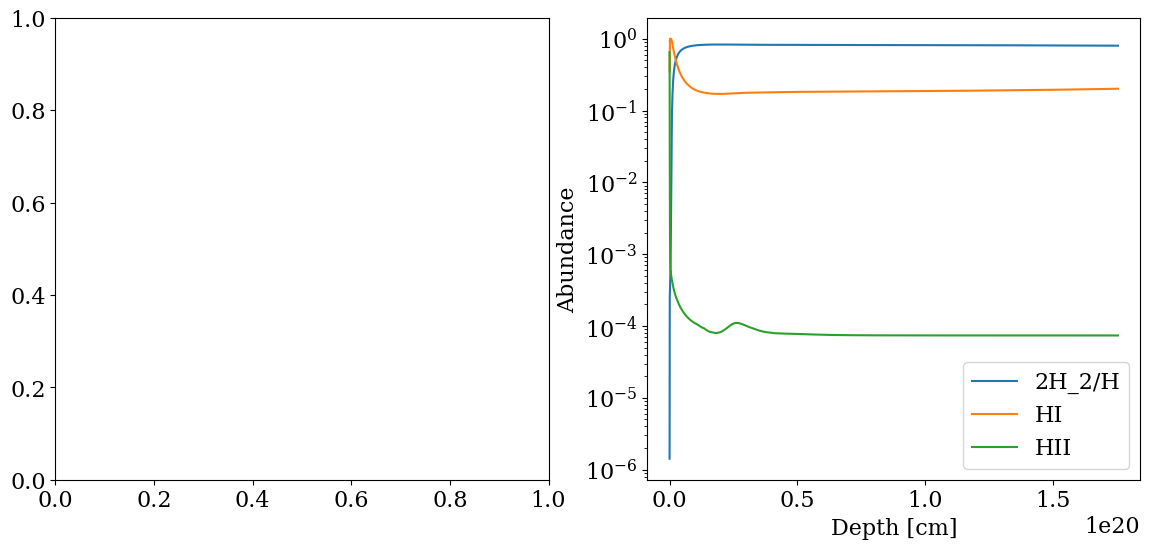

In [6]:
# columns = ['lya', 'ha', 'hb', 'co_10', 'co_21', 'co_32', 'co_43', 'co_54', 'co_65', 'co_76', 'co_87', '13co', 'c2', 'o3_88', 'o3_5006', 'o3_4958',]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

columns = ['co_10', 'co_21']
for column in columns:
    ax = axs[0]
    ax.plot(
        emissivities['depth'], 
        emissivities[column], 
        label=column
    )

ax.set_xlabel('Depth [cm]')
ax.set_ylabel('Emissivity [erg cm$^{-3}$ s$^{-1}$]')
ax.set_yscale('log')
ax.legend()



# columns = ['depth', 'Te', 'Htot', 'hden', 'eden', '2H_2/H', 'HI', 'HII', 'HeI',
#        'HeII', 'HeIII', 'CO/C', 'C1', 'C2', 'C3', 'C4', 'O1', 'O2', 'O3', 'O4',
#        'O5', 'O6', 'H2O/O']

columns = ['CO/C', 'C1', 'C2', 'C3']
for column in columns:
    ax = axs[1]
    ax.plot(
        abundances['depth'], 
        abundances[column], 
        label=column
    )
ax.set_xlabel('Depth [cm]')
ax.set_ylabel('Abundance')
ax.set_yscale('log')
ax.legend()


plt.show()




fig, axs = plt.subplots(1, 2, figsize=(14, 6))
columns = ['2H_2/H', 'HI', 'HII']
for column in columns:
    ax = axs[1]
    ax.plot(
        abundances['depth'], 
        abundances[column], 
        label=column
    )
ax.set_xlabel('Depth [cm]')
ax.set_ylabel('Abundance')
ax.set_yscale('log')
ax.legend()


plt.show()




In [ ]:
Dechenes_Lco = single_run['Lco'] # K km/s pc^2


def volume_integral(emissivity):

    max_depth = emissivity['depth'].max()
    radius = (max_depth - emissivity['depth']).to_numpy()[::-1] # cm


    volume_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()[::-1]

            volume_integrals[key] = (
                integrate.simpson(y=(emissivity_line * 4 * np.pi * radius**2), x=radius)
            ) # erg s^-1     

    Lco10 = volume_integrals['co_10']

    return Lco10

def path_integral(emissivity):

    path_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()

            path_integrals[key] = (
                integrate.simpson(y=emissivity_line, x=emissivity['depth'])
            ) # erg cm^-2 s^-1

    Fco10 = path_integrals['co_10']

    return Fco10


def path_integral_norm(emissivity):

    path_integrals = {}
    for key in emissivity.columns:
        if key != "depth":
            emissivity_line = emissivity[key].to_numpy()

            path_integrals[key] = (
                integrate.simpson(y=emissivity_line, x=emissivity['depth']) / (4 * np.pi)
            ) # erg cm^-2 s^-1

    Fco10 = path_integrals['co_10'] * np.pi

    return Fco10

co10_frequency_in_Ghz = 115.2712018 # GHz

Lco10_volume_integral = volume_integral(emissivity=emissivities)
Lco10_volume_integral = Lco10_volume_integral / 3.828e33 # Lsun
Lco10_volume_integral = Lco10_volume_integral / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2

Fco10_path_integral = path_integral(emissivity=emissivities)
area = 4 * np.pi * (single_run['radius']*constants.pc2cm)**2 # cm^2
# area = single_run['Sn'] * (constants.pc2cm)**2 # cm^2
Lco10_path_integral = Fco10_path_integral * 4 * np.pi * area # erg/s
L_co_10 = Lco10_path_integral / 3.828e33 # Lsun
Lco10_path_integral = L_co_10 / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2

Fco10_path_integral_norm = path_integral_norm(emissivity=emissivities)
area = 4 * np.pi * (single_run['radius']*constants.pc2cm)**2 # cm^2
# area = single_run['Sn'] * (constants.pc2cm)**2 # cm^2
Lco10_path_integral_norm = Fco10_path_integral_norm * 4 * np.pi * area # erg/s
L_co_10 = Lco10_path_integral_norm / 3.828e33 # Lsun
Lco10_path_integral_norm = L_co_10 / (3e-11 * co10_frequency_in_Ghz**3) # K km/s pc^2


print(f"From Dechenes+2017: Lco = {Dechenes_Lco:.2e}",)
print(f"From Interpolated Emissivities Volume Integral: Lco10 = {Lco10_volume_integral:.2e}")
print(f"From Interpolated Emissivities Path Integral: Lco10 = {Lco10_path_integral:.2e}", )
print(f"From Interpolated Emissivities Path Integral Norm: Lco10 = {Lco10_path_integral_norm:.2e}", )


In [ ]:
single_run[['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]
# single_run

In [ ]:
# all_data.iloc[[0, 5, 3, 6, 11, 7721, 7867]][['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]

# all_data.iloc[[0, 3, 7867]][['isrf', 'turbulence', 'radius', 'metallicity', 'hden', 'Lco', 'Sn']]
